# Prédicition de la variable de la consommation d'énergie des bâtiments de SEATTLE


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import missingno as msno
import FETCH_LOAD_DATAS
import ACP_functions

In [2]:
SEED = 49
rng = np.random.default_rng(SEED)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
plt.rcParams['figure.figsize'] = [10, 8]

In [5]:
data = pd.read_csv("datasets/DF_EDA.csv")

In [6]:
df = data.copy()

In [7]:
df.drop(columns='TotalGHGEmissions', inplace=True)

In [8]:
IMAGES_PATH = Path() / "img" / "prediction_conso"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"prediction_conso - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [9]:
conso = 'SiteEnergyUse(kBtu)'

In [10]:
numerical_features = list(df.describe().columns)

# Traitement des valeurs aberrantes

Nous allons nous séparer de la colonne **'ZipCode'** qui nous donne une information similaire que la colonne **'CouncilDistrictCode'** tout en étant plus difficile à interpréter. 

De même, nous allons suppprimer les colonnes **'PropertyName'**, **'DefaultData'** et **'ComplianceStatus'** car elles ne sont pas informatives pour notre problématique.

In [11]:
df.drop(columns=['ZipCode', 'PropertyName', 'DefaultData', 'ComplianceStatus'], inplace=True)
numerical_features.remove('ZipCode')

Étant donné que la plupart des distributions de nos variables suivent une loi exponentielle, nous allons leur appliquer la fonction logarithme pour voir si nous obtenons des distributions plus proches de la loi normale :

DISTRIBUTION DES VARIABLES NUMÉRIQUES


--------------------
COUNCILDISTRICTCODE




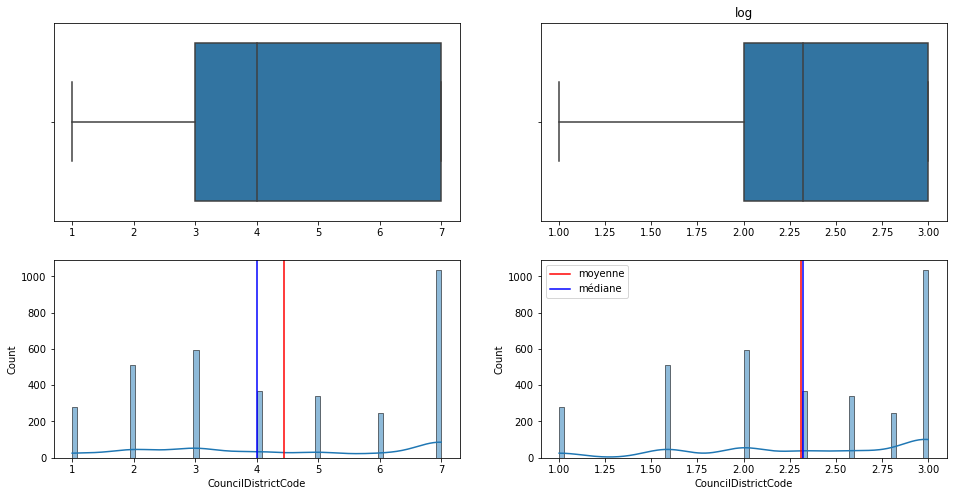

--------------------
LATITUDE




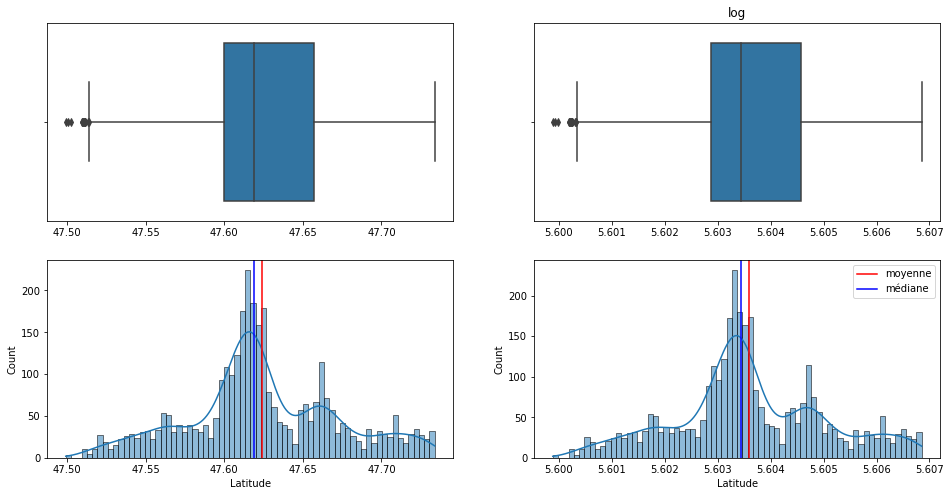

C:\Users\jkomb\anaconda3.2022\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------
LONGITUDE




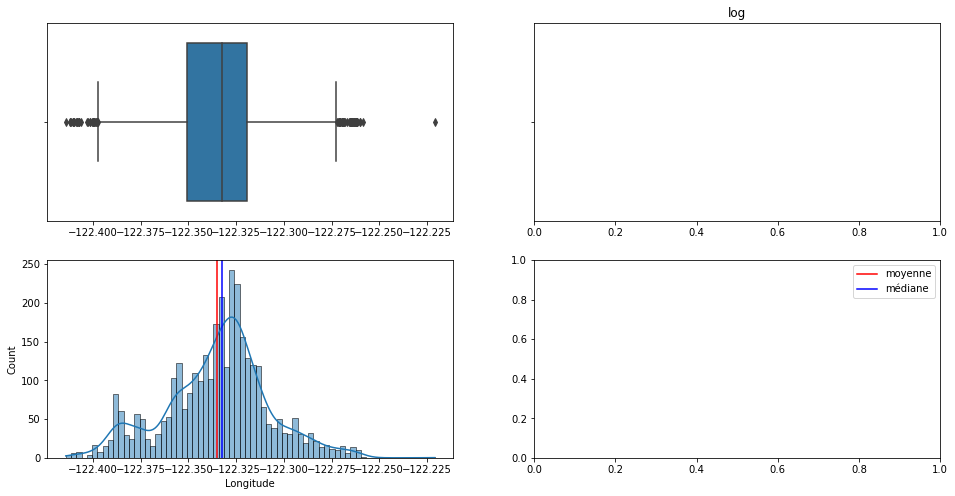

--------------------
YEARBUILT




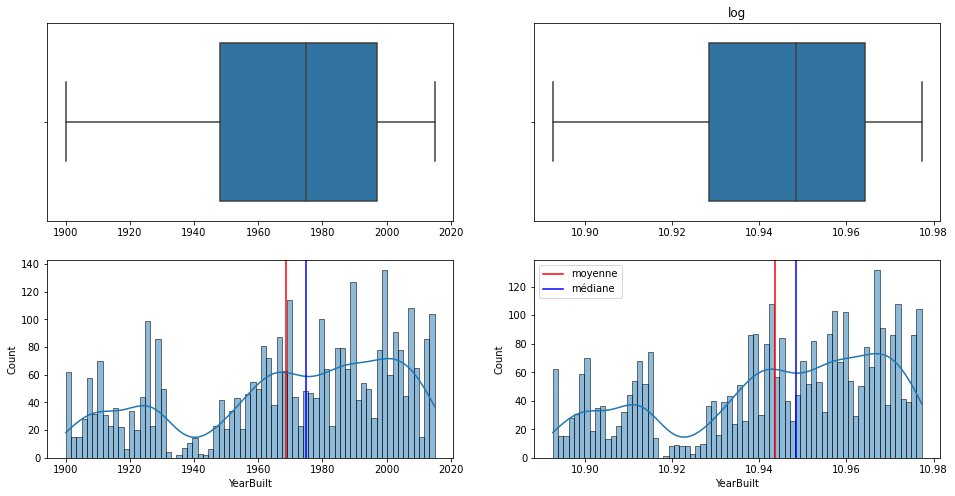

--------------------
NUMBEROFBUILDINGS




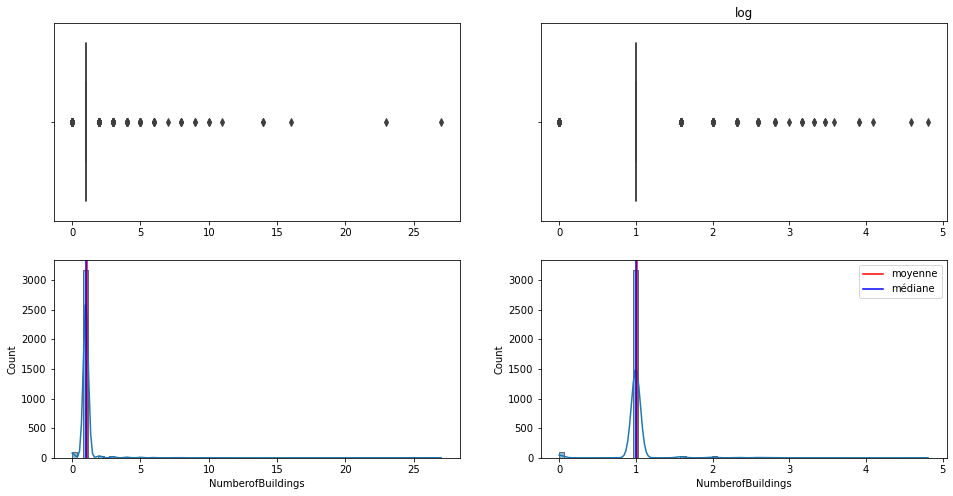

--------------------
NUMBEROFFLOORS




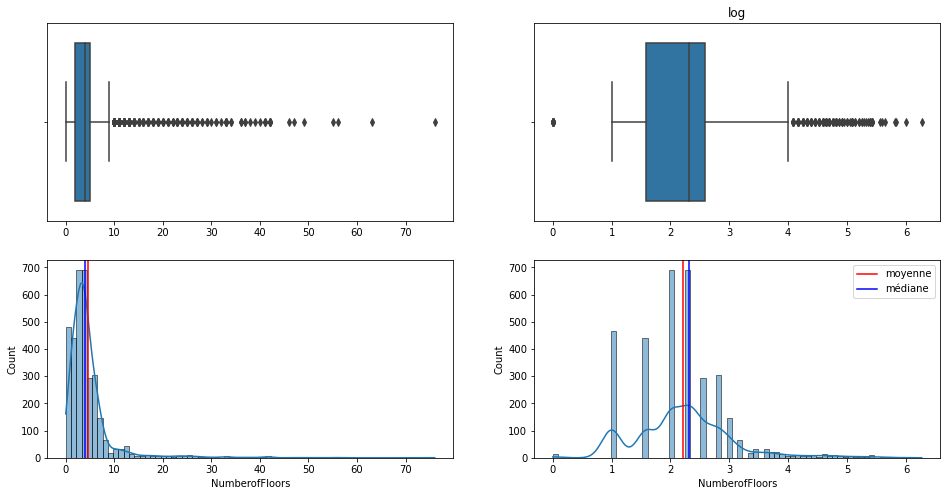

--------------------
PROPERTYGFATOTAL




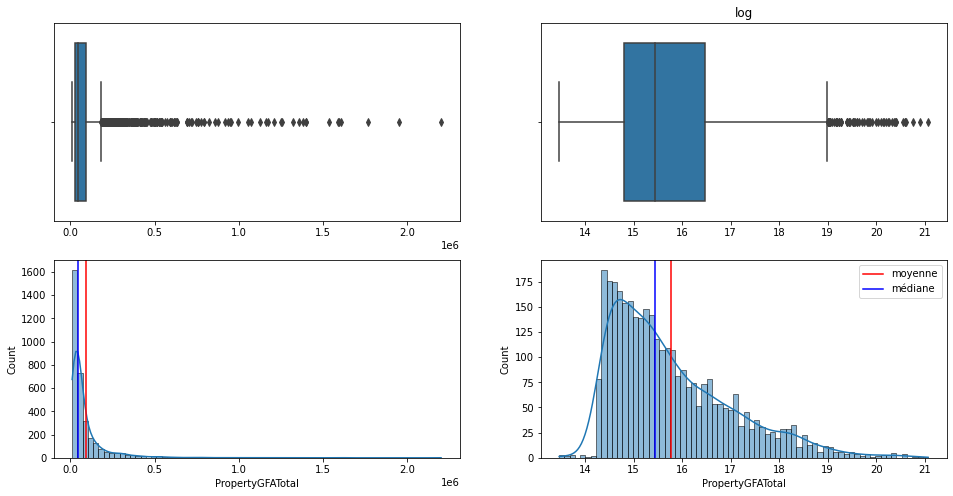

--------------------
PROPERTYGFAPARKING




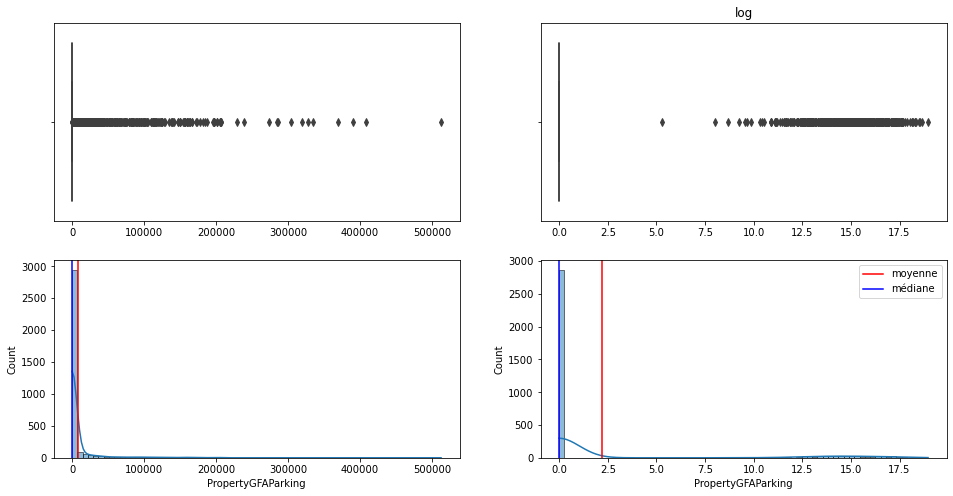

--------------------
PROPERTYGFABUILDING(S)




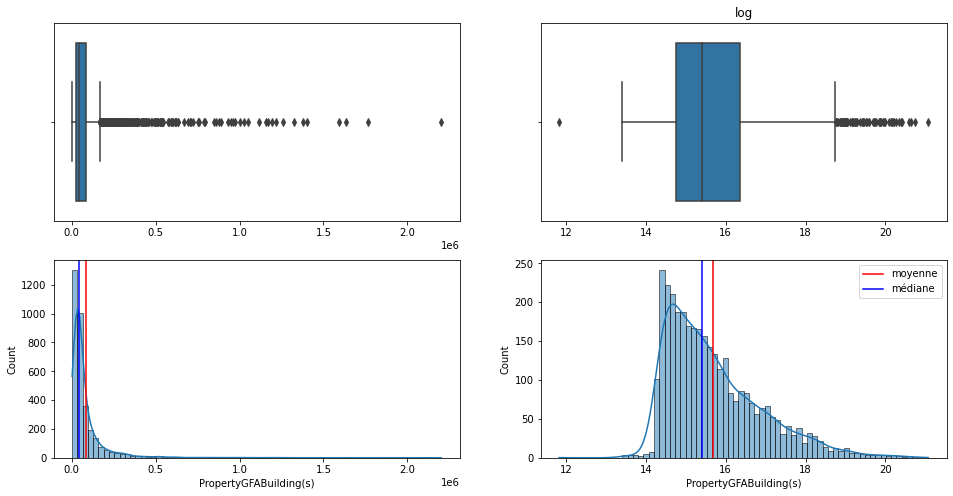

--------------------
LARGESTPROPERTYUSETYPEGFA




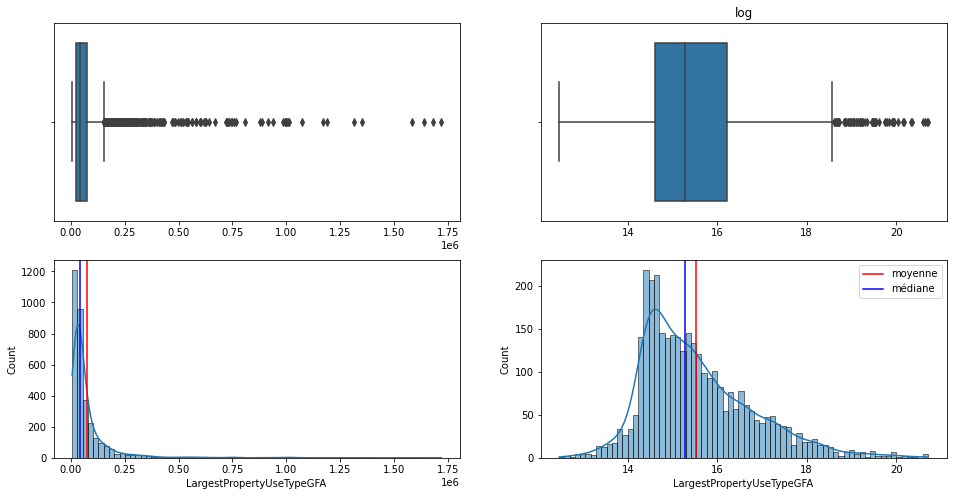

--------------------
SECONDLARGESTPROPERTYUSETYPEGFA




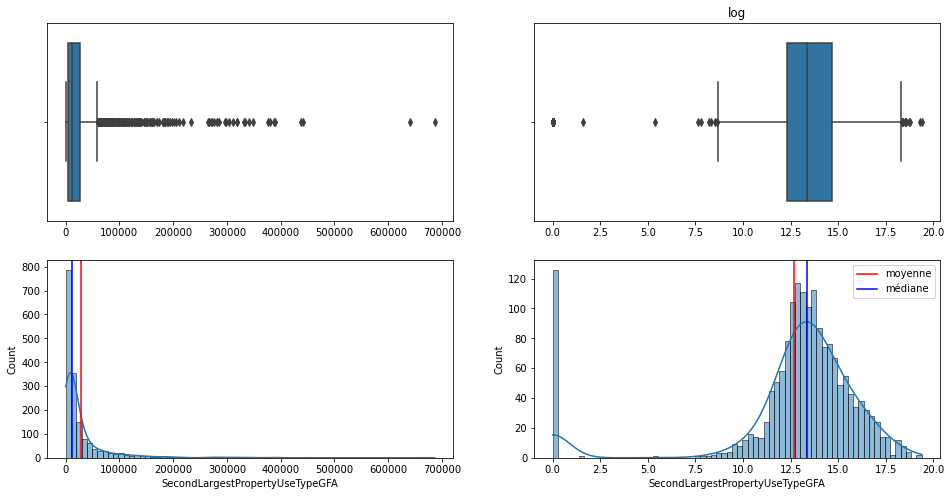

--------------------
THIRDLARGESTPROPERTYUSETYPEGFA




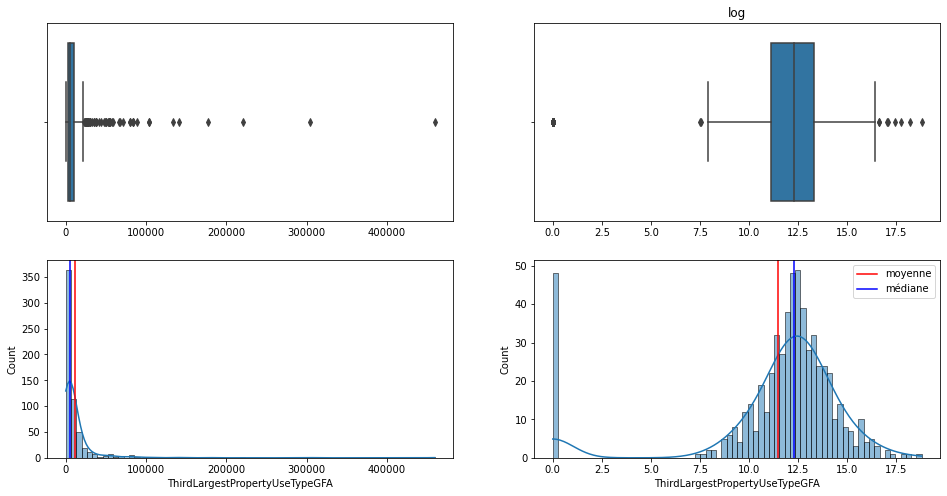

--------------------
ENERGYSTARSCORE




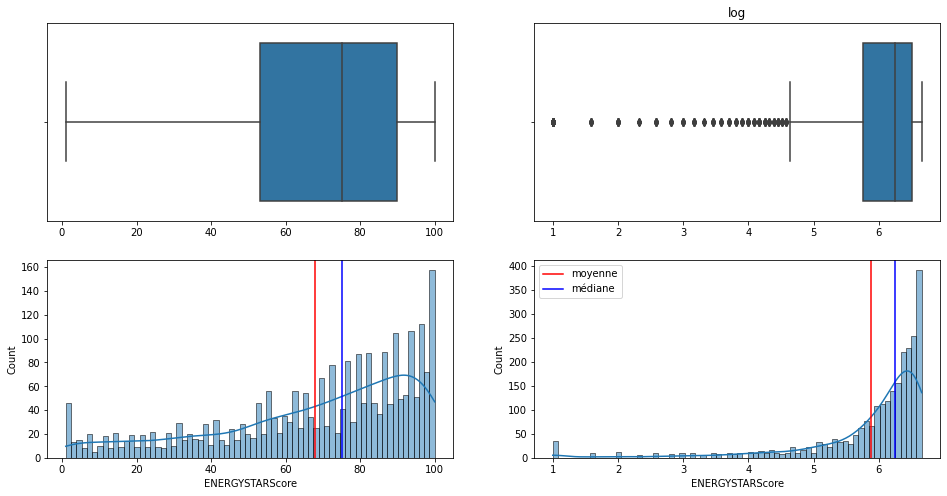

--------------------
SITEEUI(KBTU/SF)




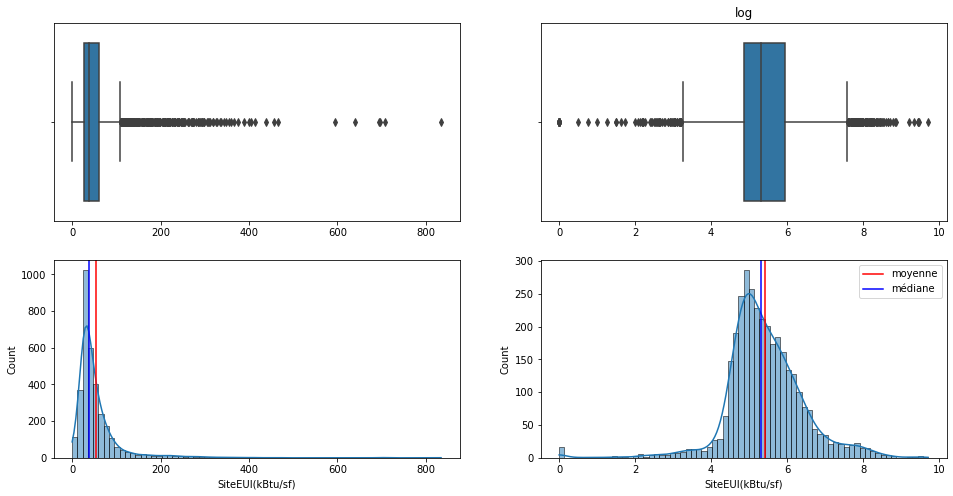

--------------------
SITEEUIWN(KBTU/SF)




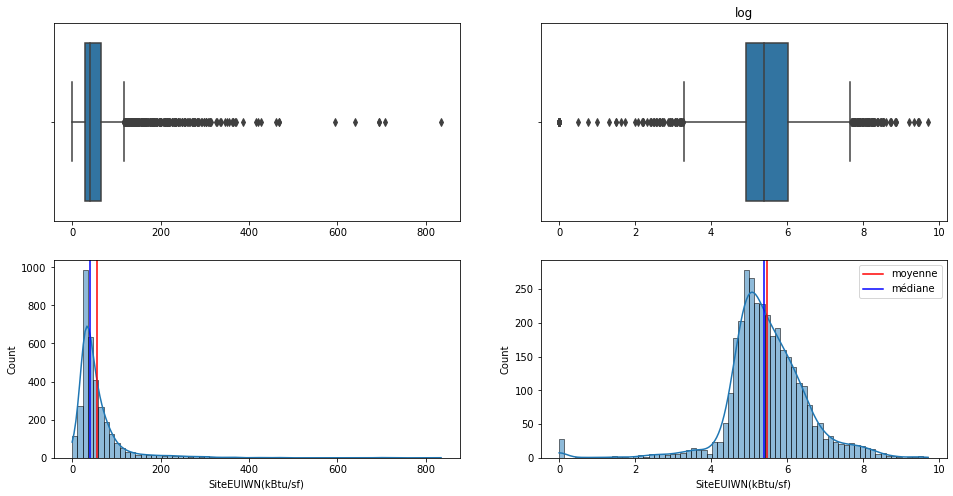

--------------------
SOURCEEUI(KBTU/SF)




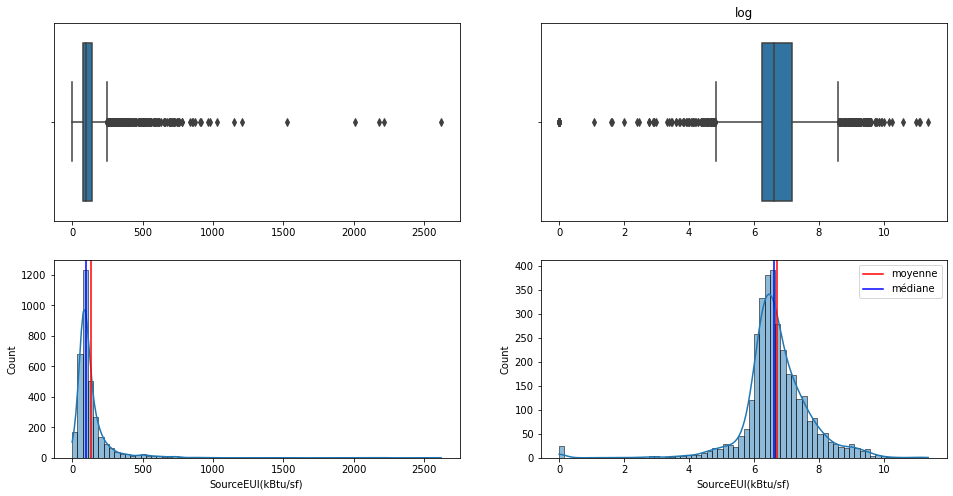

C:\Users\jkomb\anaconda3.2022\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------
SOURCEEUIWN(KBTU/SF)




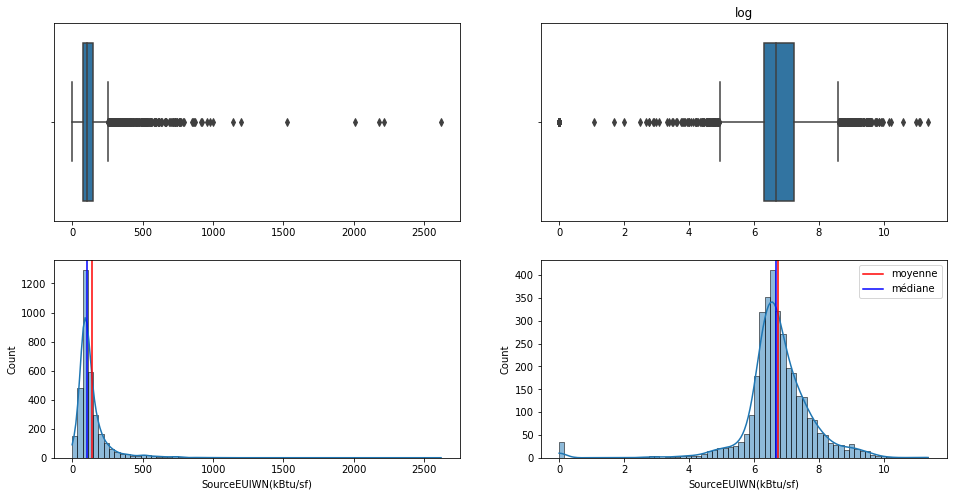

--------------------
SITEENERGYUSE(KBTU)




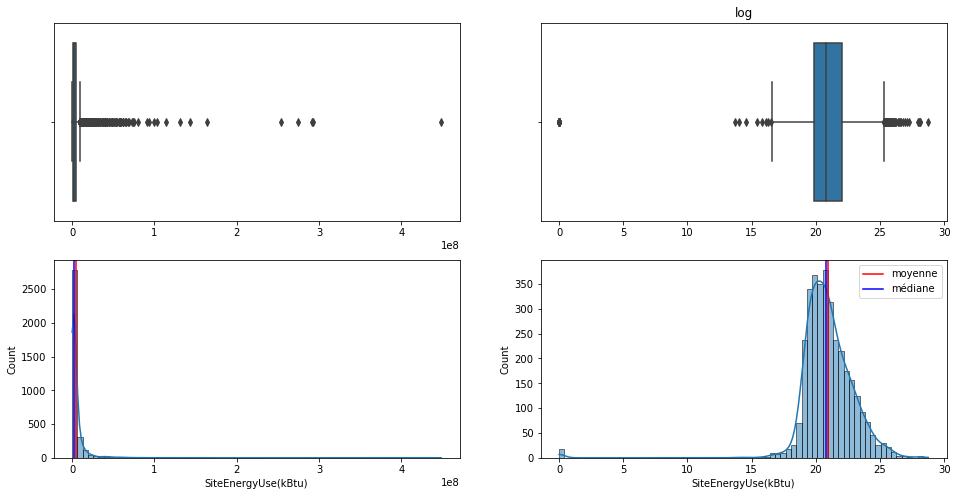

--------------------
SITEENERGYUSEWN(KBTU)




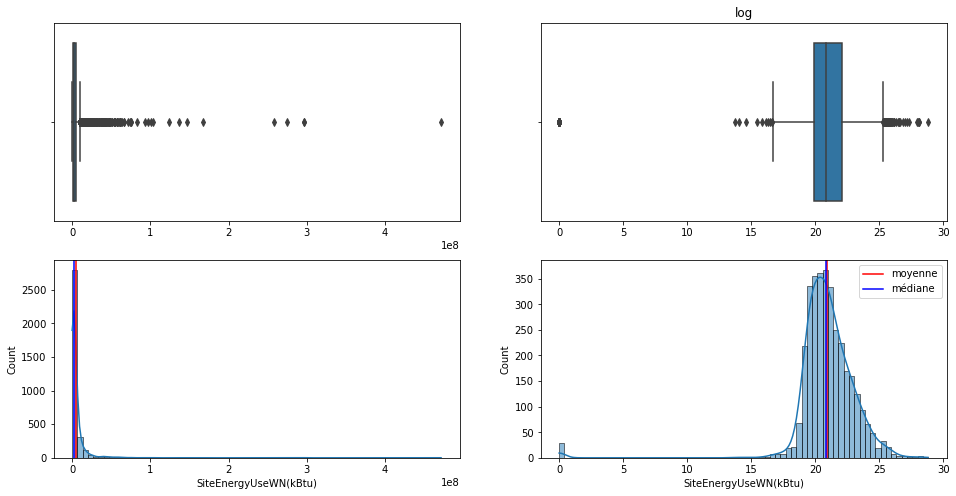

--------------------
STEAMUSE(KBTU)




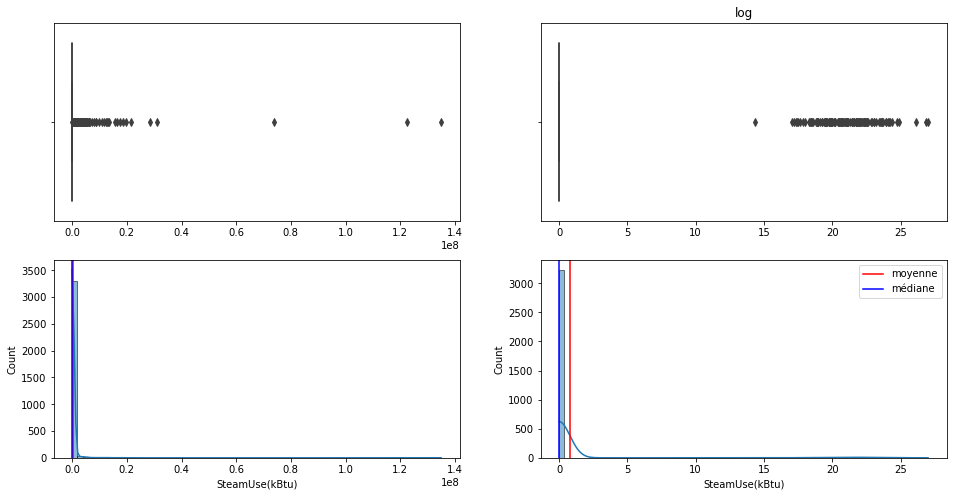

C:\Users\jkomb\anaconda3.2022\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


--------------------
ELECTRICITY(KBTU)




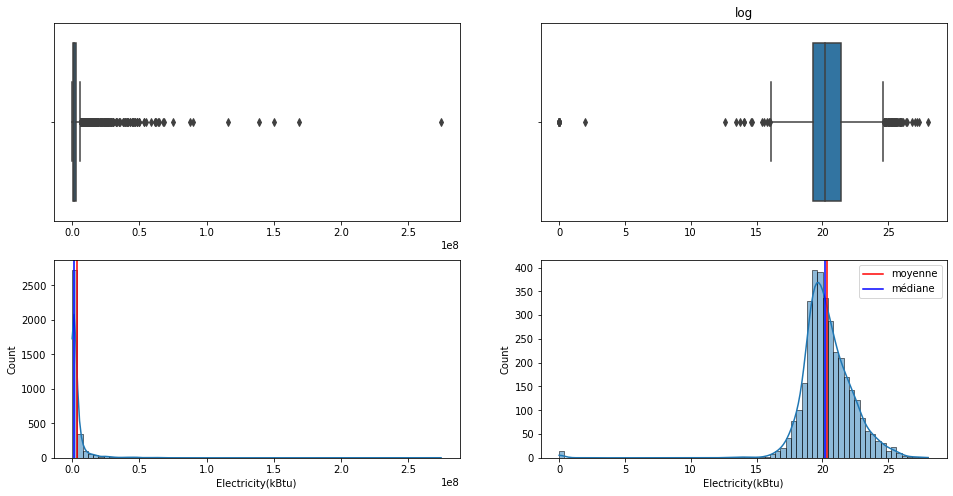

--------------------
NATURALGAS(KBTU)




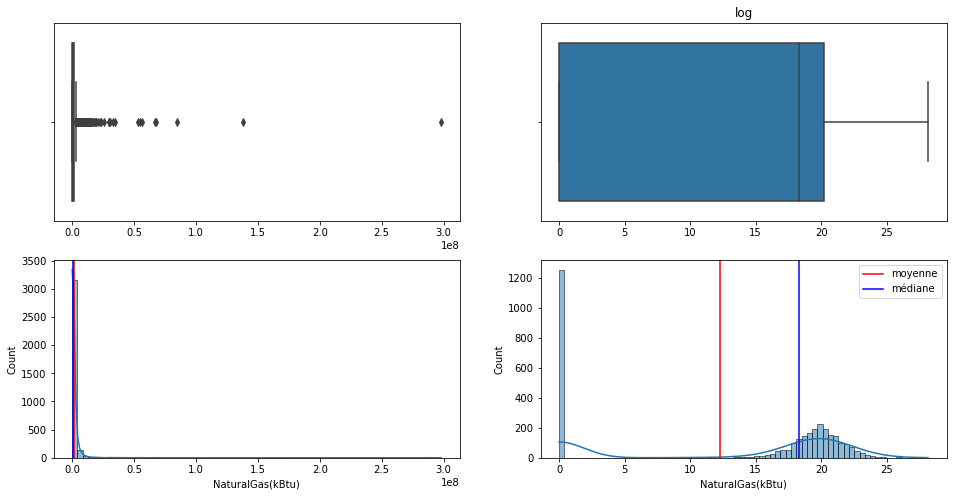

--------------------
GHGEMISSIONSINTENSITY




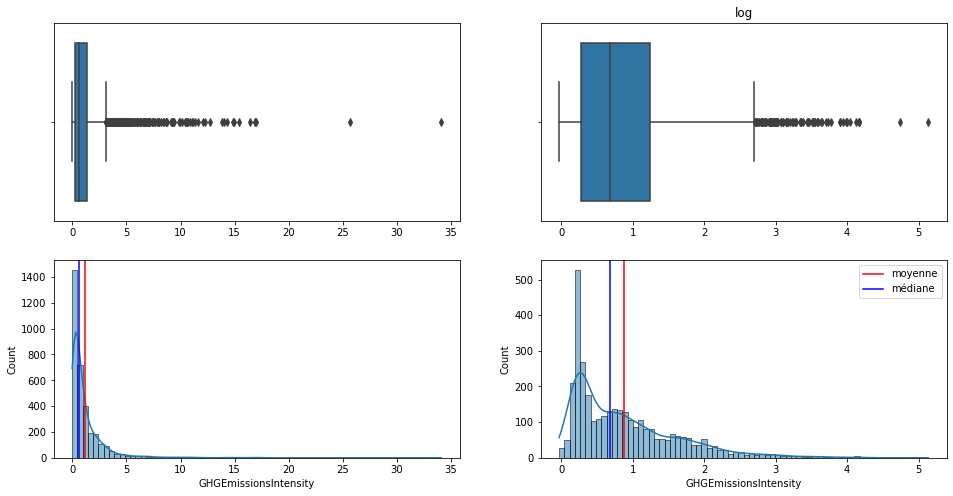

In [12]:
print('DISTRIBUTION DES VARIABLES NUMÉRIQUES')
print('\n')
for col in numerical_features:
    subset = df[col]
    log_subset = np.log2(df[col]+1)
    print("-"*20)
    print(col.upper())
    print('\n')
    fig = plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    ax1 = sns.boxplot(x=subset)
    ax1.set(xlabel=None)
    plt.subplot(2,2,3)
    ax2 = sns.histplot(x=subset, kde=True, bins=70)
    plt.axvline(x=subset.mean(), color='r', label='moyenne')
    plt.axvline(x=subset.median(), color='b', label='médiane')
    plt.subplot(2,2,2)
    plt.title("log")
    ax3 = sns.boxplot(x=log_subset)
    ax3.set(xlabel=None)
    plt.subplot(2,2,4)
    ax4 = sns.histplot(x=log_subset, kde=True, bins=70)
    plt.axvline(x=log_subset.mean(), color='r', label='moyenne')
    plt.axvline(x=log_subset.median(), color='b', label='médiane')
    plt.legend()
    plt.show()

Hormis pour les variables **'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'ENERGYSTARScore' et 'SteamUse(kBtu)', 'PropertyGFAParking', 'NumberofBuildings'**, le passage au logarithme de nos variables rapproche la forme de leurs distributions d'une distribution normale !

Du moins elle réduit pour la majorité des cas fortement l'asymétrie et le kurtosis.

**Nous allons donc passer au logarithme toutes les variables pour lesquelles cette transformation est intéressante (y compris pour notre valeur cible), afin de se rapprocher au mieux d'un jeu de données identiquement distribué**.

Les autres variables seront tout simplement normalisées.

In [13]:
log_features = numerical_features.copy()
log_features.remove('CouncilDistrictCode')
log_features.remove('Latitude')
log_features.remove('Longitude')
log_features.remove('YearBuilt')
log_features.remove('ENERGYSTARScore')
log_features.remove('SteamUse(kBtu)')
log_features.remove('PropertyGFAParking')
log_features.remove('NumberofBuildings')
log_features.remove(conso)

In [14]:
numerical_features.remove(conso)

In [15]:
std_features = list(np.setdiff1d(numerical_features, log_features))

Pour traiter nos valeurs aberrantes, nous allons commencer par répertorier tous les portefeuilles de bâtiments ayant un **Z-score** supérieur à 3 en valeur absolue pour l'une de nos variables quantitatives :

In [16]:
df_outlier = zscore(df[numerical_features], axis=0, nan_policy='omit')

In [17]:
L_ind_outlier = list()
for ind in df_outlier.index:
    for col in df_outlier.columns:
        if np.abs(df_outlier.loc[ind, col]) > 3:
            L_ind_outlier.append(ind)  
            
L_ind_outlier = list(set(L_ind_outlier))
len(L_ind_outlier)

307

In [18]:
df.drop(index=L_ind_outlier, inplace=True)

# Traitement des valeurs manquantes

In [19]:
df.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
0,NonResidential,Hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,2.83
1,NonResidential,Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,2.86
3,NonResidential,Hotel,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,4.67
4,NonResidential,Hotel,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,2.88
5,Nonresidential COS,Other,7,DOWNTOWN,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,136.100006,141.600006,316.299988,320.500000,12086616.0,12581712.0,0.00,7371434.0,4715182.0,3.10


<AxesSubplot:>

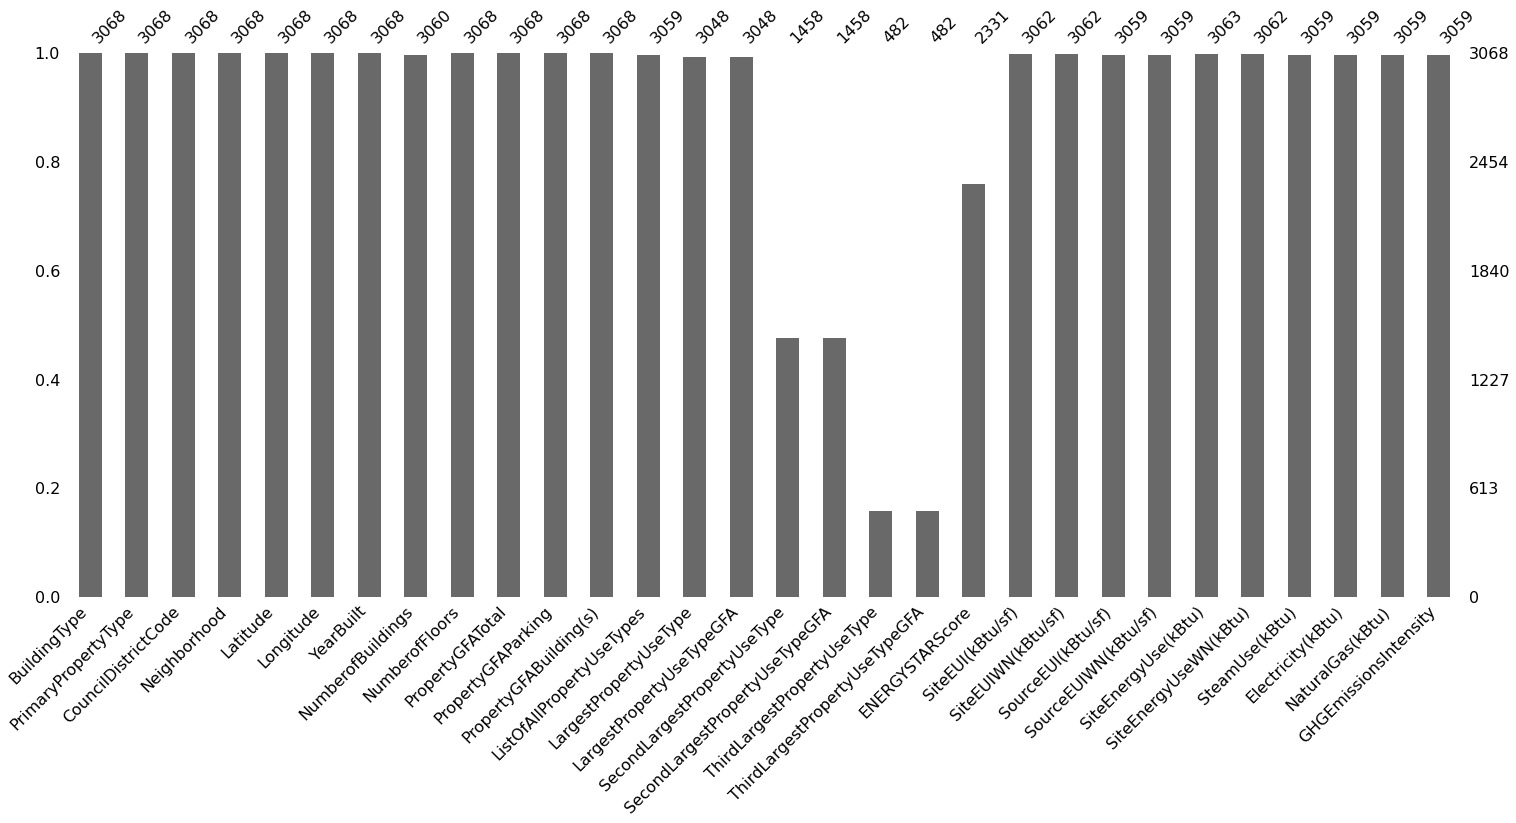

In [20]:
msno.bar(df)

Avant toue chose, comme le précise l'énoncé de mission, nous allons effectuer un tri pour ne conserver que les bâtiments non résidentiels du jeu de données.

In [21]:
df['BuildingType'].value_counts()

NonResidential          1250
Multifamily LR (1-4)    1000
Multifamily MR (5-9)     569
SPS-District K-12         98
Multifamily HR (10+)      72
Nonresidential COS        71
Campus                     7
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [22]:
df = df[~df['BuildingType'].str.contains('family')]

In [23]:
df.shape

(1427, 30)

Les bâtiments résidentiels sont également caractérisés par la présence du mot-clé **'family'** dans la liste de leur usage :

In [24]:
df['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    285
Other                          197
Warehouse                      186
K-12 School                    137
Large Office                   103
Mixed Use Property              93
Retail Store                    85
Worship Facility                71
Hotel                           65
Distribution Center             52
Medical Office                  32
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           16
University                      16
Supermarket / Grocery Store     13
Refrigerated Warehouse          11
Restaurant                       7
Low-Rise Multifamily             3
Office                           3
Laboratory                       2
Hospital                         1
Name: PrimaryPropertyType, dtype: int64

In [25]:
df = df[~df['PrimaryPropertyType'].fillna('').str.contains('family')]

In [26]:
df['ListOfAllPropertyUseTypes'].str.contains('family').value_counts()

False    1391
True       31
Name: ListOfAllPropertyUseTypes, dtype: int64

In [27]:
df = df[~df['ListOfAllPropertyUseTypes'].fillna('').str.contains('family')]

In [28]:
df.shape

(1393, 30)

In [29]:
df['LargestPropertyUseType'].str.contains('family').value_counts()

False    1387
Name: LargestPropertyUseType, dtype: int64

In [30]:
df['SecondLargestPropertyUseType'].str.contains('family').value_counts()

False    651
Name: SecondLargestPropertyUseType, dtype: int64

In [31]:
df['ThirdLargestPropertyUseType'].str.contains('family').value_counts()

False    237
Name: ThirdLargestPropertyUseType, dtype: int64

<AxesSubplot:>

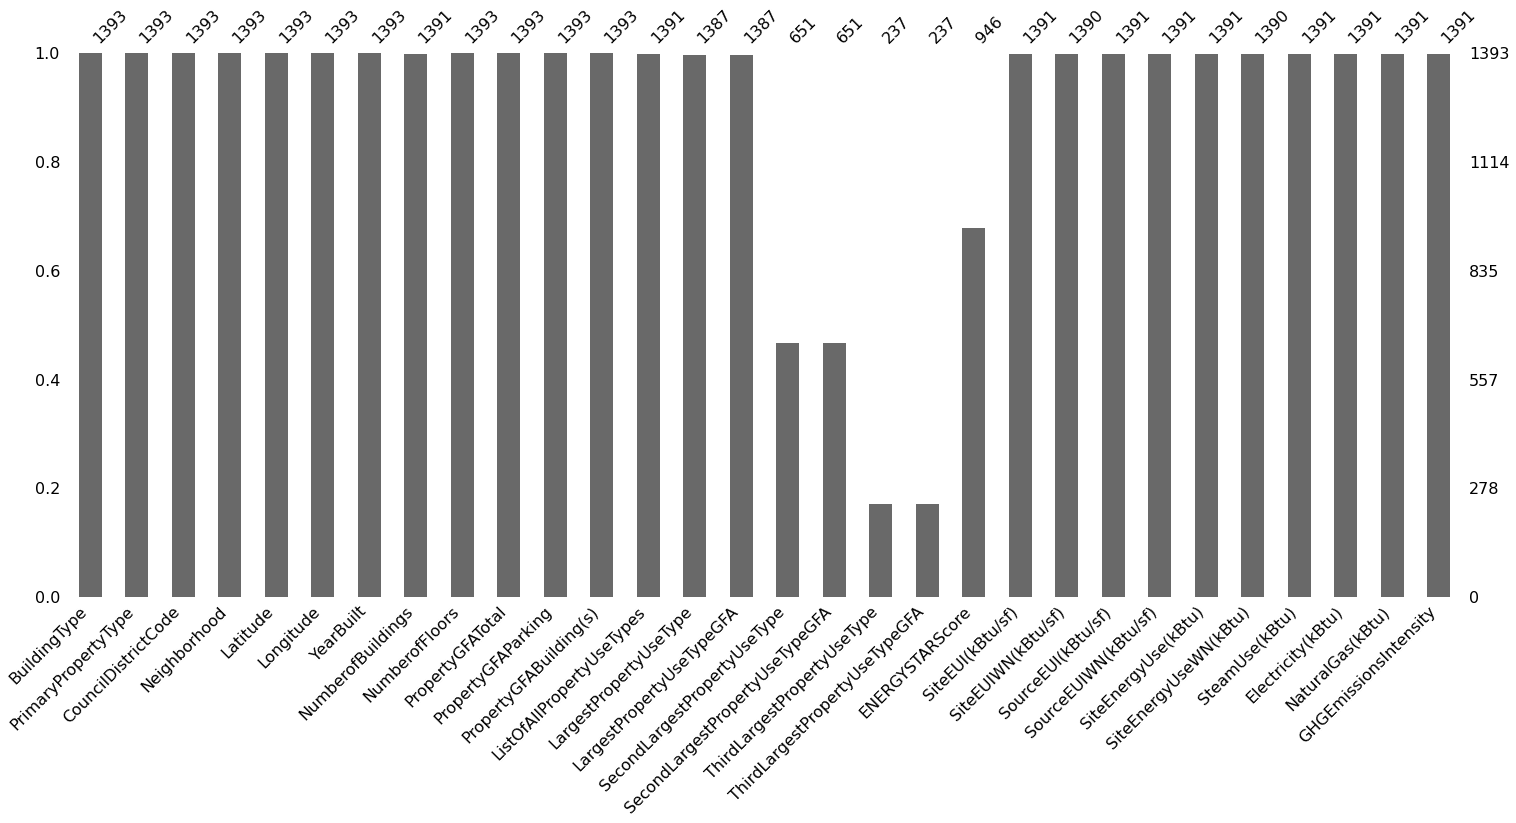

In [32]:
msno.bar(df)

In [33]:
df.isna().mean().mean()

0.10244077530509688

In [34]:
df.reset_index(inplace=True, drop=True)

Pour le traitement des données manquantes, nous allons tout simplement procéder colonne par colonne, de gauche à droite du jeu de données :

In [35]:
df.isna().mean()[df.isna().mean()!=0.]

NumberofBuildings                  0.001436
ListOfAllPropertyUseTypes          0.001436
LargestPropertyUseType             0.004307
LargestPropertyUseTypeGFA          0.004307
SecondLargestPropertyUseType       0.532663
SecondLargestPropertyUseTypeGFA    0.532663
ThirdLargestPropertyUseType        0.829864
ThirdLargestPropertyUseTypeGFA     0.829864
ENERGYSTARScore                    0.320890
SiteEUI(kBtu/sf)                   0.001436
SiteEUIWN(kBtu/sf)                 0.002154
SourceEUI(kBtu/sf)                 0.001436
SourceEUIWN(kBtu/sf)               0.001436
SiteEnergyUse(kBtu)                0.001436
SiteEnergyUseWN(kBtu)              0.002154
SteamUse(kBtu)                     0.001436
Electricity(kBtu)                  0.001436
NaturalGas(kBtu)                   0.001436
GHGEmissionsIntensity              0.001436
dtype: float64

In [36]:
df[df['NumberofBuildings'].isna()]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
434,NonResidential,Small- and Mid-Sized Office,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1201,NonResidential,Mixed Use Property,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous décidons de supprimer ces 2 entrées de notre jeu de données car elles possèdent trop de valeurs manquantes parmi les variables de consommation d'énergie/émission de gaz à effet de serre.

In [37]:
df.drop(index=df[df['NumberofBuildings'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [38]:
df.isna().mean()[df.isna().mean()!=0.]

LargestPropertyUseType             0.002876
LargestPropertyUseTypeGFA          0.002876
SecondLargestPropertyUseType       0.531991
SecondLargestPropertyUseTypeGFA    0.531991
ThirdLargestPropertyUseType        0.829619
ThirdLargestPropertyUseTypeGFA     0.829619
ENERGYSTARScore                    0.319914
SiteEUIWN(kBtu/sf)                 0.000719
SiteEnergyUseWN(kBtu)              0.000719
dtype: float64

In [39]:
df[df['LargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
258,NonResidential,Self-Storage Facility,6,BALLARD,47.66838,-122.39310,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.799999,51.000000,103.000000,106.400002,5.697472e+06,6.076957e+06,0.0,3007514.0,2689958.0,1.47
661,NonResidential,Hotel,7,DOWNTOWN,47.61203,-122.34165,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,NaN,NaN,NaN,NaN,93.0,52.200001,53.500000,150.399994,154.399994,2.897080e+06,2.968430e+06,0.0,2534592.0,362488.0,0.60
1135,NonResidential,Small- and Mid-Sized Office,4,LAKE UNION,47.64747,-122.34086,2008,1.0,4,48350,0,48350,Office,NaN,NaN,NaN,NaN,NaN,NaN,45.0,72.199997,74.699997,226.600006,234.600006,3.168131e+06,3.280956e+06,0.0,3168131.0,0.0,0.46
1151,NonResidential,Restaurant,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.200001,32.500000,62.000000,62.799999,8.999242e+05,9.358332e+05,0.0,402907.0,497017.0,1.01


Nous assignons à ces 4 portefeuilles leur unique usage dans **'LargestPropertyUseType'** d'après la colonne **'ListOfAllPropertyUseTypes'**, sinon le premier usage de cette liste.

In [40]:
df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('LargestPropertyUseType')] = df.iloc[df[df['LargestPropertyUseType'].isna()].index, df.columns.get_loc('ListOfAllPropertyUseTypes')].apply(lambda x: x.split(',')[0])

De même nous assignons à ces 4 portefeuilles la valeur  **'PropertyGFATotal'** dans leur colonne **'LargestPropertyUseTypeGFA'**.

In [41]:
df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('LargestPropertyUseTypeGFA')] = df.iloc[df[df['LargestPropertyUseTypeGFA'].isna()].index, df.columns.get_loc('PropertyGFATotal')]

In [42]:
df.isna().mean()[df.isna().mean()!=0.]

SecondLargestPropertyUseType       0.531991
SecondLargestPropertyUseTypeGFA    0.531991
ThirdLargestPropertyUseType        0.829619
ThirdLargestPropertyUseTypeGFA     0.829619
ENERGYSTARScore                    0.319914
SiteEUIWN(kBtu/sf)                 0.000719
SiteEnergyUseWN(kBtu)              0.000719
dtype: float64

In [43]:
df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    735
4      4
3      1
Name: LargestPropertyUseType, dtype: int64

In [44]:
df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0).value_counts()

1    1148
4       5
3       1
Name: LargestPropertyUseType, dtype: int64

Nous pouvons constater dans les 2 dernières cellules, que les valeurs manquantes des colonnes **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent quasiment toutes être mises à la valeur **0** car elles correspondent à des portefeuilles de bâtiments n'ayant qu'un seul usage pour la très grande majorité :

In [45]:
df[df['SecondLargestPropertyUseType'].isna()][df[df['SecondLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
89,Nonresidential COS,Other,2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,3.03
962,NonResidential,Other,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,0.47
1105,NonResidential,Other,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,1.65
1286,NonResidential,Other,3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,0.22
1358,Nonresidential COS,Other,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,0.51


In [46]:
df[df['ThirdLargestPropertyUseType'].isna()][df[df['ThirdLargestPropertyUseType'].isna()]['LargestPropertyUseType'].str.split(',').apply(lambda x: len(x) if isinstance(x,list) else 0)!=1]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
89,Nonresidential COS,Other,2,GREATER DUWAMISH,47.595450,-122.321460,1950,1.0,1,67356,0,67356,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",68359.0,NaN,NaN,NaN,NaN,NaN,109.400002,118.300003,242.699997,252.100006,7.475578e+06,8.086930e+06,0.0,4182001.0,3293576.0,3.03
868,NonResidential,Other,1,DELRIDGE,47.533660,-122.337330,1963,1.0,1,23260,0,23260,"Office, Repair Services (Vehicle, Shoe, Locksm...","Repair Services (Vehicle, Shoe, Locksmith, etc)",13075.0,Office,10185.0,NaN,NaN,NaN,69.300003,77.500000,137.399994,146.100006,1.612106e+06,1.803515e+06,0.0,719779.0,892327.0,2.25
962,NonResidential,Other,2,GREATER DUWAMISH,47.593220,-122.324910,1920,1.0,4,20600,0,20600,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20600.0,NaN,NaN,NaN,NaN,NaN,13.100000,15.500000,24.100000,27.000000,2.708385e+05,3.187032e+05,0.0,101274.0,169565.0,0.47
1105,NonResidential,Other,5,NORTH,47.716200,-122.295600,1960,1.0,1,25406,0,25406,"Personal Services (Health/Beauty, Dry Cleaning...","Personal Services (Health/Beauty, Dry Cleaning...",25406.0,NaN,NaN,NaN,NaN,NaN,96.099998,97.800003,257.399994,259.100006,2.442220e+06,2.484502e+06,0.0,1901857.0,540363.0,1.65
1286,NonResidential,Other,3,EAST,47.613403,-122.320351,1907,1.0,2,22320,0,22320,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",22320.0,NaN,NaN,NaN,NaN,NaN,9.400000,10.300000,22.700001,23.700001,2.096449e+05,2.309889e+05,0.0,137286.0,72359.0,0.22
1358,Nonresidential COS,Other,2,GREATER DUWAMISH,47.595230,-122.323340,2014,1.0,1,20993,0,20993,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc)",20983.0,NaN,NaN,NaN,NaN,NaN,44.000000,45.799999,125.400002,129.699997,9.238128e+05,9.616286e+05,0.0,795829.0,98912.0,0.51


Nous constatons dans les 2 dernières cellules que les portefeuilles de bâtiments 'problématiques' ont des valeurs de **'PropertyGFATotal'** et **'LargestPropertyUseTypeGFA'** identiques, sauf pour le portefeuille de bâtiment déclinant un second usage de ses surfaces.

Nous considérons donc que les valeurs manquantes des colonnes :
   - **'SecondLargestPropertyUseType'** et **'ThirdLargestPropertyUseType'** peuvent être mises à **None** (pas d'autre usage des surfaces du bâtiment que l'usage principal)
   - **'SecondLargestPropertyUseTypeGFA'** et **'ThirdLargestPropertyUseTypeGFA'** peuvent être mises à **0**

In [47]:
df['SecondLargestPropertyUseType'].fillna('None', inplace=True)
df['ThirdLargestPropertyUseType'].fillna('None', inplace=True)
df['SecondLargestPropertyUseTypeGFA'].fillna(0, inplace=True)
df['ThirdLargestPropertyUseTypeGFA'].fillna(0, inplace=True)

Nous n'avons désormais plus besoin de la colonne **'ListOfAllPropertyUseTypes'**:

In [48]:
df.drop(columns='ListOfAllPropertyUseTypes', inplace=True)

In [49]:
df.isna().mean()[df.isna().mean()!=0.]

ENERGYSTARScore          0.319914
SiteEUIWN(kBtu/sf)       0.000719
SiteEnergyUseWN(kBtu)    0.000719
dtype: float64

In [50]:
df.drop(index=df[df['SiteEUI(kBtu/sf)'].isna()].index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [51]:
df[df['SiteEUIWN(kBtu/sf)'].isna()]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
423,NonResidential,Large Office,7,DOWNTOWN,47.61051,-122.34439,1979,1.0,7,131143,87160,43983,Office,120248.0,Retail Store,10853.0,None,0.0,93.0,39.5,NaN,128.0,0.0,5177270.5,NaN,0.0,4871126.0,1416041.0,0.83


In [52]:
df.corr()[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']].loc[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']]

,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu)
SiteEUI(kBtu/sf),1.000000,0.991170,0.560347,0.557007
SiteEUIWN(kBtu/sf),0.991170,1.000000,0.534625,0.547880
SiteEnergyUse(kBtu),0.560347,0.534625,1.000000,0.987083
SiteEnergyUseWN(kBtu),0.557007,0.547880,0.987083,1.000000


Étant donné le très grand coefficient de corrélation linéaire entre les paires de colonnes **('SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)')** et **('SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)')** (>0,985), nous allons tout simplement imputer la valeur manquante dans les colonnes **SiteEUIWN(kBtu/sf)** et **SiteEnergyUseWN(kBtu)** en entraînant une régression linéaire au sein de chacune des paires de variables citées ci-avant (*nous considérons la fuite de données vis-à-vis de l'ultérieure séparation en jeu d'entraînement et jeu de test négligeable pour l'imputation de 2 valeurs*) :

Nous décidons de supprimer cette entrée car elle manque d'un trop grand nombre de valeurs pour nos variables pertinentes (dont nos valeurs cibles).

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut

In [54]:
y_1 = df[df['SiteEUIWN(kBtu/sf)'].notna()]['SiteEUIWN(kBtu/sf)']
X_1 = df[df['SiteEUIWN(kBtu/sf)'].notna()]['SiteEUI(kBtu/sf)'].to_numpy().reshape(-1, 1)

y_2 = df[df['SiteEnergyUseWN(kBtu)'].notna()]['SiteEnergyUseWN(kBtu)']
X_2 = df[df['SiteEnergyUseWN(kBtu)'].notna()]['SiteEnergyUse(kBtu)'].to_numpy().reshape(-1, 1)

In [55]:
cv=10

cross_score_1 = cross_val_score(LinearRegression(), StandardScaler().fit_transform(X_1), y_1, scoring='r2', 
                                cv=KFold(n_splits=cv, shuffle=True, random_state=SEED))
cross_score_2 = cross_val_score(LinearRegression(), StandardScaler().fit_transform(X_2), y_2, scoring='r2', 
                                cv=KFold(n_splits=cv, shuffle=True, random_state=SEED))

cross_score_1.mean(), cross_score_2.mean()

(0.9797028358887114, 0.9682053473575412)

In [56]:
lin_reg_1, lin_reg_2 = LinearRegression(), LinearRegression()
lin_reg_1.fit(StandardScaler().fit_transform(X_1), y_1)
lin_reg_2.fit(StandardScaler().fit_transform(X_2), y_2)

LinearRegression()

In [57]:
df.loc[df[df['SiteEUIWN(kBtu/sf)'].isna()].index,'SiteEUIWN(kBtu/sf)'] = lin_reg_1.predict(df[df['SiteEUIWN(kBtu/sf)'].isna()]['SiteEUI(kBtu/sf)'].to_numpy().reshape(1, -1))
df.loc[df[df['SiteEnergyUseWN(kBtu)'].isna()].index,'SiteEnergyUseWN(kBtu)'] = lin_reg_2.predict(df[df['SiteEnergyUseWN(kBtu)'].isna()]['SiteEnergyUse(kBtu)'].to_numpy().reshape(1, -1))

In [58]:
df.isna().mean()[df.isna().mean()!=0.]

ENERGYSTARScore    0.319914
dtype: float64

<AxesSubplot:>

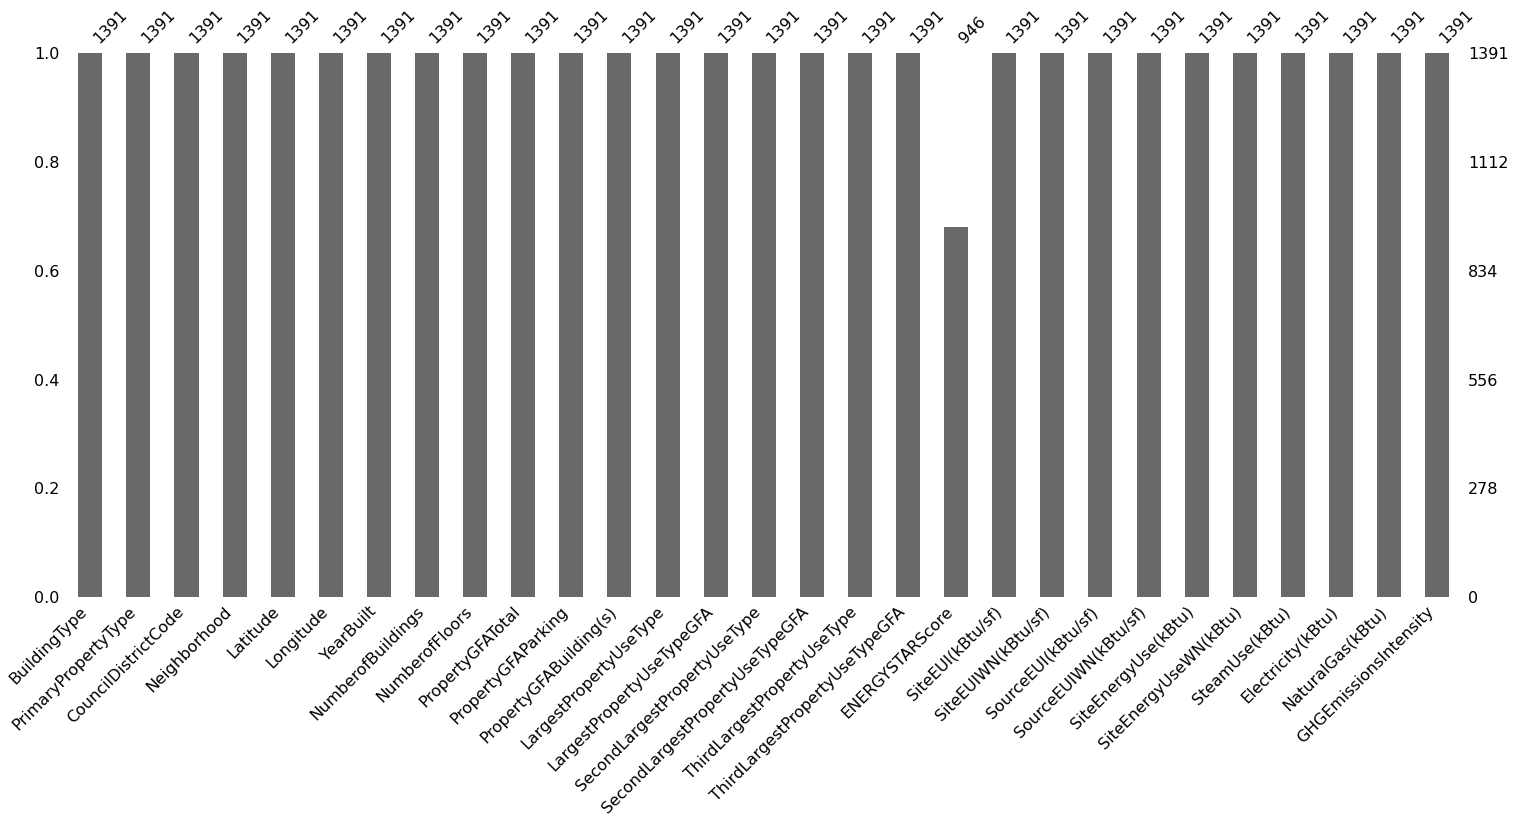

In [59]:
msno.bar(df)

Pour le traitement des valeurs manquantes de la colonne **ENERGYSTARScore**, nous allons tout d'abord restreindre le jeu de données à l'ensemble des portefeuilles des bâtiments n'ayant pas de valeur manquante dans cette colonne, puis nous allons amputer des valeurs à la colonne **ENERGYSTARScore** et comparer les valeurs imputées par différentes méthodes aux valeurs initiales.

La méthode ayant effectué les meilleurs imputations sur l'ensemble de jeux de données de validation que nous allons générer, sera retenue pour réaliser l'imputation des valeurs manquantes de la colonne entière.

Mais avant toute chose, nous séparons notre jeu de données en un jeu d'entraînement et un jeu de test afin de prévenir la fuite de données :

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=conso), df[conso], test_size=0.2, random_state=24*SEED)

In [62]:
X_train['ENERGYSTARScore'].isna().mean(), X_test['ENERGYSTARScore'].isna().mean()

(0.3210431654676259, 0.3154121863799283)

Nous avons des taux de valeurs manquantes similaires dans nos jeux d'entraînement et de test, ce qui est rassurant, sinon nous aurions dû effectuer un découpage stratifié pour équilibrer ces valeurs.

En effet, la méthode d'imputation choisie le sera dans le contexte d'un certain taux de valeurs manquantes, pour un taux très différent, et surtout plus élevé, la méthode choisie pourrait différer...

In [63]:
index_notna_ENERGYSTAR = X_train[X_train['ENERGYSTARScore'].notna()].index
df_select_imp = X_train.loc[index_notna_ENERGYSTAR, numerical_features]

<AxesSubplot:>

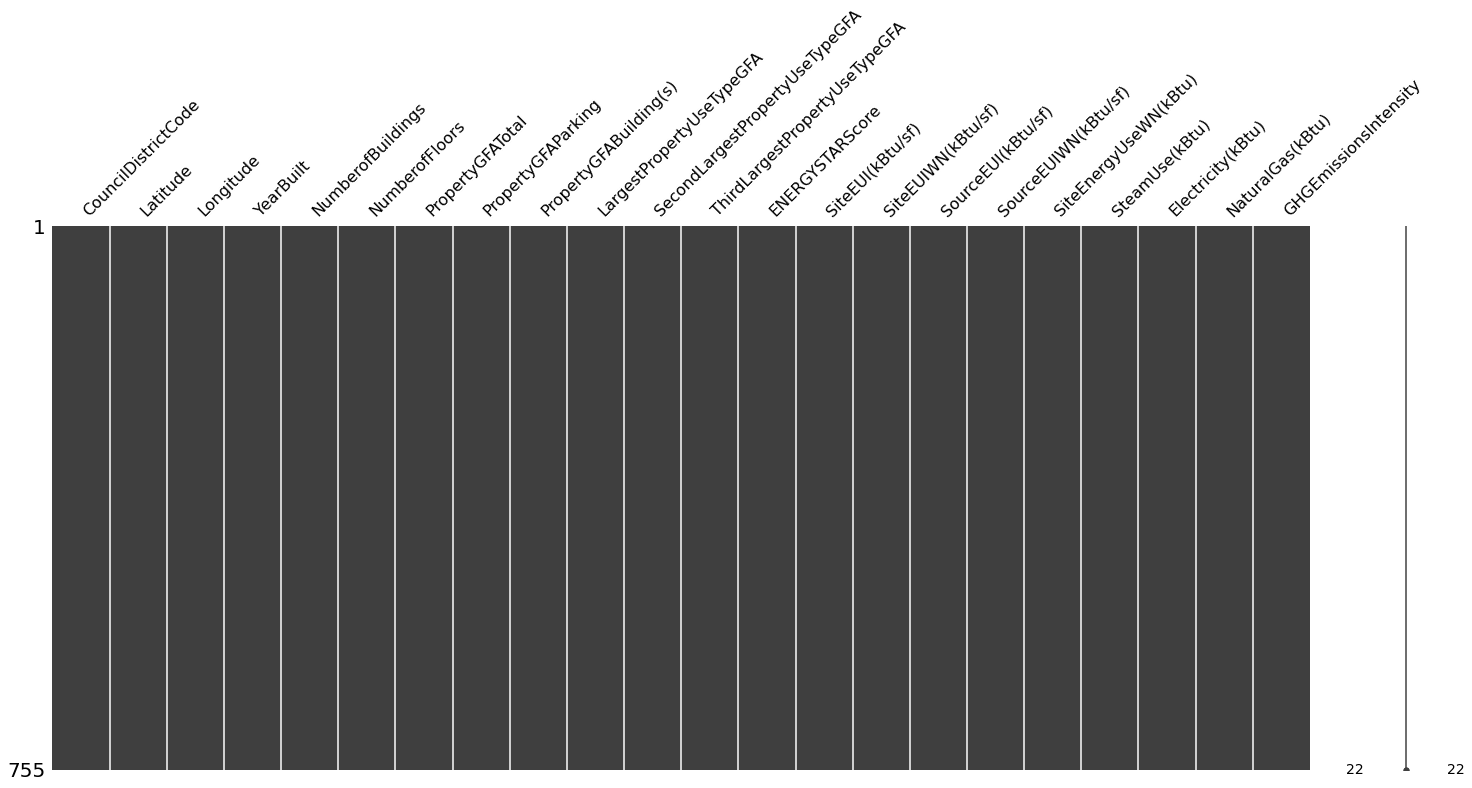

In [64]:
msno.matrix(df_select_imp)

Nous définissons dans un premier temps une fonction nous permettant d'amputer des valeurs dans un DataFrame et de stocker leurs indices pour une comparaison ultérieure des valeurs imputées avec les valeurs amputées.

In [65]:
def ampute_data(data,
                variables = None,
                pct_amp = 0.1,
                random_state = None):
    
    amputed_data = data.copy()
    amp_rows = int(pct_amp * data.shape[0])
    dict_index = dict()
    dict_index['amp_rows_size'] = amp_rows
    
    
    if random_state is None:
        rng = np.random.default_rng(seed=2022)
    else:
        rng = np.random.default_rng(seed=int(random_state))

    if variables is None:
        variables = [col for col in amputed_data.columns]
    elif isinstance(variables, list):
        if isinstance(variables[0], int):
            variables = [data.columns[i] for i in variables]
    
    dict_index['amp_total_size'] = amp_rows*len(variables)

    for v in variables:
        notna_index = amputed_data[amputed_data.loc[:,v].notna()].index
        amp_ind = rng.choice(notna_index, replace=False, size=amp_rows)
        amputed_data.loc[amp_ind, v] = np.nan
        dict_index[v]=amp_ind
    
    return amputed_data, dict_index

Nous définissons également une fonction nous permettant de visualiser la distribution de la variable **ENERGYSTARScore** avant et après imputation :

In [66]:
def plot_imputation(X_imputed):
    if isinstance(X_imputed, np.ndarray):
        X_imputed = pd.DataFrame(X_imputed, columns='ENERGYSTARScore')
    data = X_imputed.copy()
    col='ENERGYSTARScore'
    plt.figure(figsize=(12,18))

        
    sns.histplot(df_select_imp[col], stat='density', color='blue', alpha=0.6)
    sns.histplot(data[col], stat='density',  color='orange', alpha=0.4)
    
    plt.axvline(df_select_imp[col].mean(), color='green', ymin=0.5, alpha=0.5, label='moyenne initiale')
    plt.axvline(df_select_imp[col].median(), color='blue', ymin=0.5, alpha=0.5, label='médiane initiale')
    plt.axvline(data[col].mean(), color='red', ymax=0.4, alpha=0.9, label='nouvelle moyenne')
    plt.axvline(data[col].median(), color='black', ymax=0.4, alpha=0.5, label='nouvelle médiane')
    
    plt.legend(loc='upper left')
    
    plt.show()

Nous allons tester les méthodes d'imputation suivantes :
   1. **SimpleImputer** (imputation par la moyenne)
   2. **SimpleImputer** (imputation par la médiane)
   3. **KNNImputer** (k plus proche voisins allant de 1 à 15)
   4. **IterativeImputer**
   5. **MICE** (Multiple Imputation Chained Equations)

In [67]:
imputer_select_seeds = list(rng.integers(low=0, high=10000, size=5))

In [68]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf

from sklearn.metrics import mean_squared_error

Dans un premier temps nous générons un dictionnaire contenant 5 jeux de données avec différentes amputations de la colonne **ENERGYSTARScore**, ensuite nous imputerons ces différents jeux à l'aide des 3 méthodes citées plus haut afin de les comparer.

Nous allons utiliser un pourcentage d'imputation égal au taux de valeurs manquantes dans la colonne entière **ENERGYSTARScore** afin de nous rapprocher au plus des conditions dans lesquelles nous devrons véritablement utiliser l'imputation.

In [69]:
pct_amp = X_train['ENERGYSTARScore'].isna().mean()
pct_amp

0.3210431654676259

In [70]:
dict_df_amp = dict()

for seed in imputer_select_seeds:
    dict_df_amp[imputer_select_seeds.index(seed)] = tuple(ampute_data(df_select_imp, 
                                                                variables=['ENERGYSTARScore'], 
                                                                pct_amp=pct_amp, 
                                                                random_state=seed))

In [71]:
dict_mean_imputer = dict()

for key in dict_df_amp.keys():
    data = dict_df_amp[key][0].copy()
    mean_imputer = SimpleImputer()
    dict_mean_imputer[key] = pd.DataFrame(mean_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [72]:
dict_median_imputer = dict()

for key in dict_df_amp.keys():
    data = dict_df_amp[key][0].copy()
    median_imputer = SimpleImputer(strategy='median')
    dict_median_imputer[key] = pd.DataFrame(median_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [73]:
dict_knnimputer = dict()
kmin=5
kmax=20

for k in range(kmin,kmax):
    dict_knnimputer[k] = list()
    for key in dict_df_amp.keys():
        data = dict_df_amp[key][0].copy()
        knn_imputer = KNNImputer(n_neighbors=k, weights="uniform")
        dict_knnimputer[k].append(pd.DataFrame(knn_imputer.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index))

In [74]:
dict_iterativeimp = dict()

for key in dict_df_amp.keys():
        data = dict_df_amp[key][0].copy()
        iter_imp = IterativeImputer(random_state=SEED)
        dict_iterativeimp[key]= pd.DataFrame(iter_imp.fit_transform(data), columns=df_select_imp.columns, index=df_select_imp.index)

In [75]:
dict_mice = dict()

# on instancie un nombre d'observation voisines de l'observation contenant la valeur manquante, à considérer comme candidat 
# pour baser notre l'imputation
scheme_candidate = mf.mean_match_shap.copy()
scheme_candidate.set_mean_match_candidates(5)

for key in dict_df_amp.keys():
    dict_mice[key] = list()
    data = dict_df_amp[key][0].copy()
    # On crée le noyau
    kernel = mf.ImputationKernel(data,
                      datasets=4, # on crée 4 datasets d'imputations différents pour évaluer la distribution de l'imputation
                      mean_match_scheme=scheme_candidate,
                      save_all_iterations=True,
                      random_state=SEED)

    # on procède à 10 itérations de l'algorithme en espérant que les imputations convergent
    kernel.mice(10)
    
    dict_mice[key].append(kernel)
    dict_mice[key].append(kernel.complete_data())

Maintenant que nous avons tous nos jeux de données imputées, nous allons pouvoir calculer le score **Root Mean Square Error** obtenu sur chacun d'entre eux, ainsi que leur moyenne pour chacune des méthodes d'imputation :

In [76]:
list_rmse_mean = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_mean_imputer[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_mean.append(np.round(rmse,2))

In [77]:
list_rmse_median = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_median_imputer[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_median.append(np.round(rmse,2))

In [78]:
dict_rmse_knn = dict()

for k in range(kmin,kmax):
    dict_rmse_knn[k] = list()
    for key in dict_df_amp.keys():
        index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
        rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                      dict_knnimputer[k][key].loc[index_amp,'ENERGYSTARScore'], squared=False)
        dict_rmse_knn[k].append(np.round(rmse,2))

In [79]:
list_rmse_iter = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_iterativeimp[key].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_iter.append(np.round(rmse,2))

In [80]:
list_rmse_mice = list()

for key in dict_df_amp.keys():
    index_amp = dict_df_amp[key][1]['ENERGYSTARScore']
    rmse = mean_squared_error(df_select_imp.loc[index_amp,'ENERGYSTARScore'], 
                  dict_mice[key][1].loc[index_amp,'ENERGYSTARScore'], squared=False)
    list_rmse_mice.append(np.round(rmse,2))

In [81]:
dict_comparison_imp = {'mean':list_rmse_mean,
                       'median':list_rmse_median,
                       'iterative':list_rmse_iter,
                       'mice':list_rmse_mice}

In [82]:
for key in dict_knnimputer.keys():
    comp_key = f"knn k={key}"
    dict_comparison_imp[comp_key]=dict_rmse_knn[key]

In [83]:
df_comp_imp = pd.DataFrame(dict_comparison_imp)

In [84]:
df_comp_imp

,mean,median,iterative,mice,knn k=5,knn k=6,knn k=7,knn k=8,knn k=9,knn k=10,knn k=11,knn k=12,knn k=13,knn k=14,knn k=15,knn k=16,knn k=17,knn k=18,knn k=19
0,26.26,27.02,23.16,26.47,27.65,27.39,27.39,26.95,26.76,26.81,26.76,26.83,26.62,26.62,26.49,26.55,26.32,26.25,26.34
1,26.53,28.18,22.12,23.83,28.02,27.62,27.61,27.25,26.91,27.00,27.05,27.10,26.86,26.80,26.55,26.38,26.31,26.23,26.21
2,27.71,28.54,679468.31,26.77,28.50,28.27,28.10,27.90,27.58,27.39,27.37,27.22,27.27,27.18,27.07,27.10,27.05,26.97,26.86
3,27.29,28.78,25665.30,24.64,29.82,29.27,28.44,28.44,28.19,27.93,27.55,27.17,27.07,26.99,26.82,26.71,26.61,26.61,26.51
4,29.30,29.79,24.47,24.02,28.57,28.59,27.96,27.94,27.39,27.46,27.57,27.69,27.64,27.75,27.80,27.94,27.92,27.91,27.99


In [85]:
df_comp_imp.describe()

,mean,median,iterative,mice,knn k=5,knn k=6,knn k=7,knn k=8,knn k=9,knn k=10,knn k=11,knn k=12,knn k=13,knn k=14,knn k=15,knn k=16,knn k=17,knn k=18,knn k=19
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000
mean,27.418000,28.462000,141040.672000,25.146000,28.512000,28.228000,27.900000,27.696000,27.366000,27.318000,27.260000,27.202000,27.092000,27.068000,26.946000,26.936000,26.84200,26.794000,26.782000
std,1.201362,1.003703,301194.927643,1.382581,0.821505,0.756717,0.412129,0.593742,0.570202,0.435626,0.348712,0.311561,0.390218,0.434822,0.530406,0.621313,0.67355,0.693599,0.717962
min,26.260000,27.020000,22.120000,23.830000,27.650000,27.390000,27.390000,26.950000,26.760000,26.810000,26.760000,26.830000,26.620000,26.620000,26.490000,26.380000,26.31000,26.230000,26.210000
25%,26.530000,28.180000,23.160000,24.020000,28.020000,27.620000,27.610000,27.250000,26.910000,27.000000,27.050000,27.100000,26.860000,26.800000,26.550000,26.550000,26.32000,26.250000,26.340000
50%,27.290000,28.540000,24.470000,24.640000,28.500000,28.270000,27.960000,27.900000,27.390000,27.390000,27.370000,27.170000,27.070000,26.990000,26.820000,26.710000,26.61000,26.610000,26.510000
75%,27.710000,28.780000,25665.300000,26.470000,28.570000,28.590000,28.100000,27.940000,27.580000,27.460000,27.550000,27.220000,27.270000,27.180000,27.070000,27.100000,27.05000,26.970000,26.860000
max,29.300000,29.790000,679468.310000,26.770000,29.820000,29.270000,28.440000,28.440000,28.190000,27.930000,27.570000,27.690000,27.640000,27.750000,27.800000,27.940000,27.92000,27.910000,27.990000


La meilleur méthode d'imputation est celle de l'algorithme **MICE**.

Regardons d'un peu plus près les caractéristiques de l'imputation qu'il génère :

In [86]:
# Nous choisissons le noyau généré par l'algorithme sur le 3ème jeu de données de validation
kernel = dict_mice[2][0]

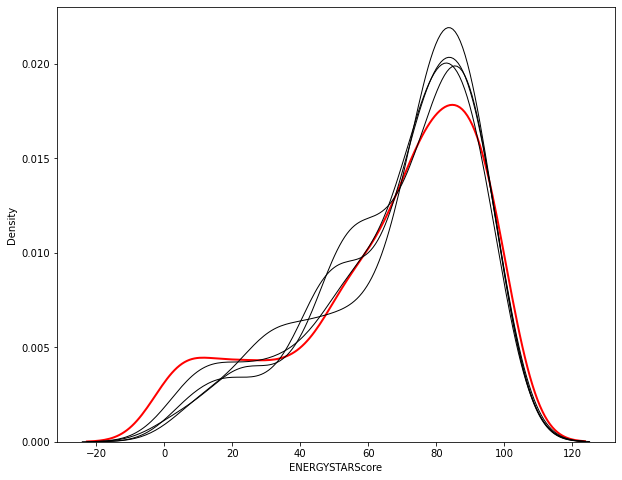

In [87]:
# Distribution de la variable imputée dans chacun des datasets (4) générés pour le deuxième jeu de donnée de validation

kernel.plot_imputed_distributions(wspace=0.3,
                                  hspace=0.3, 
                                  variables=['ENERGYSTARScore'])

Ci-dessous nous pouvons remarquer que l'algorithme converge très rapidement vers ses estimations finales !

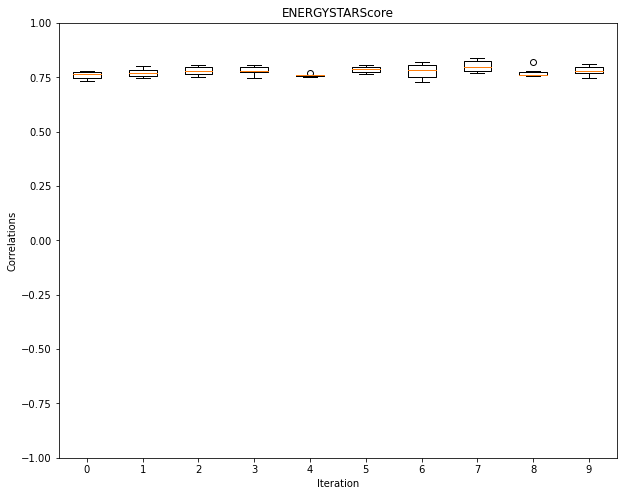

In [88]:
# Évolution de la distribution de la corrélation de distribution entre les datasets imputés et la distribution
# des données non manquantes

kernel.plot_correlations(variables=['ENERGYSTARScore'])

Ci-dessous nous pouvons observer qu'aucune variable ne sort du lot dans l'importance qu'elle revêt dans l'imputation de notre colonne **ENERGYSTARScore**. 

Cela ne nous étonne guère, car nous savons depuis la fin de l'analyse exploratoire qu'il s'agit de la variable la moins corrélée aux autres de toutes les variables numériques (voir illustration "exploration - 70" représentant les clusters de corrélations).

AxesSubplot(0.125,0.125;0.62x0.755)


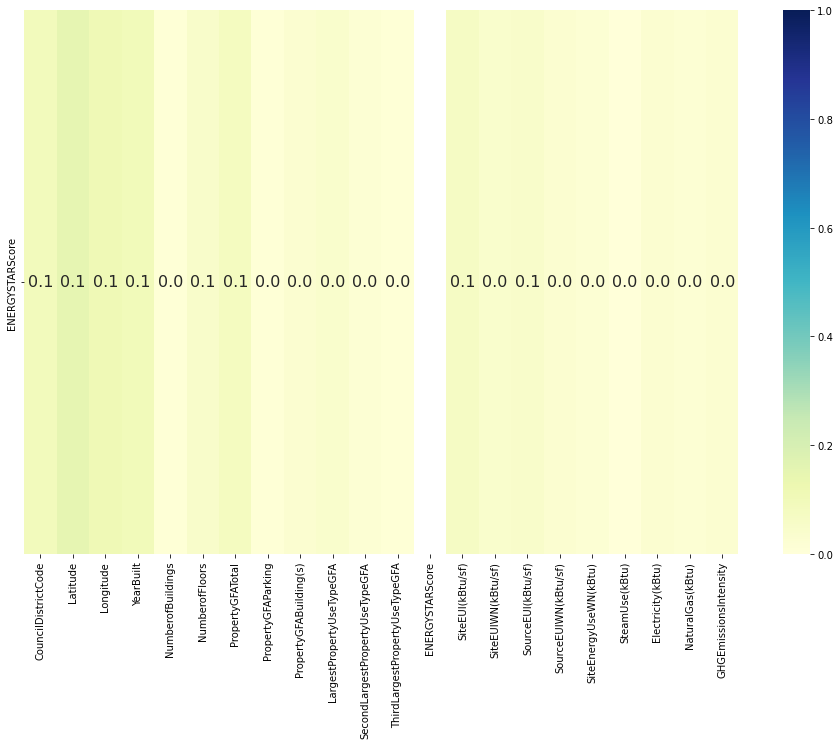

In [89]:
# Diagramme d'importance des variables dans l'imputation

plt.figure(figsize=(16,10))
kernel.plot_feature_importance(dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1,fmt=".1f")

Enfin, nous pouvons observer si la moyenne de nos imputations finit par converger.

Ici, nous y sommes presque, il aurait peut-être fallu quelques itérations de plus pour arriver à une moyenne stable.

Cependant, étant donné que la convergence de la moyenne des imputations n'arrive pas dès les premières itérations, cela nous informe que les données manquantes étaient bien manquantes aléatoirement, et donc notre fonction d'amputation fait bien son travail.

In [90]:
# ajouter des graphiques utilisant la fonction 'plot_imputation' pour illustrer !!!!!!!!!!

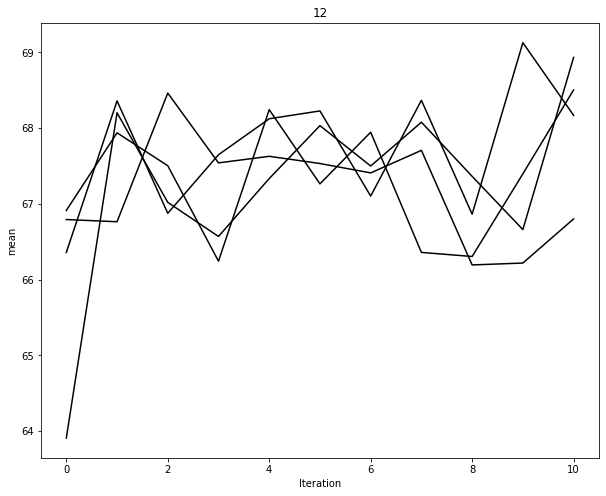

In [91]:
# Évolution des moyennes des imputations en fonction des itérations
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)

Imputons maintenant les valeurs manquantes dans nos jeux d'entraînement et de test :

In [92]:
kernel_train = mf.ImputationKernel(X_train[numerical_features],
                                    mean_match_scheme=scheme_candidate,
                                    random_state=SEED)

kernel_train.mice(4)
X_train_imp = kernel_train.complete_data()

kernel_test = kernel_train.impute_new_data(X_test[numerical_features])
X_test_imp = kernel_test.complete_data(0)

X_train['ENERGYSTARScore'] = X_train_imp['ENERGYSTARScore']
X_test['ENERGYSTARScore'] = X_test_imp['ENERGYSTARScore']

X_train.isna().mean().mean(), X_test.isna().mean().mean()

(0.0, 0.0)

## Automatisation du pré-traitement des données

Après avoir séparer notre jeu de données en un jeu d'entraînement et un jeu de test, à ce stade nous pouvons appliquer le processsus suivant :

In [93]:
cat_features = list(X_train.select_dtypes(include='object').columns)
numerical_features_ind = [df.drop(columns=conso).columns.get_loc(ft) for ft in numerical_features]
log_features_ind = [df.drop(columns=conso).columns.get_loc(ft) for ft in log_features]
std_features_ind = [df.drop(columns=conso).columns.get_loc(ft) for ft in std_features]
cat_features_ind = [df.drop(columns=conso).columns.get_loc(ft) for ft in cat_features]

In [95]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

def log_tr(X):
    return np.log2(X+1)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=conso), df[conso], test_size=0.2, random_state=24*SEED)

kernel_imp_ft_train = mf.ImputationKernel(X_train[numerical_features], 
                                        mean_match_scheme=scheme_candidate, 
                                        random_state=SEED)

kernel_imp_ft_train.mice(4)
X_num_train_imp = kernel_imp_ft_train.complete_data()

kernel_imp_ft_test = kernel_imp_ft_train.impute_new_data(X_test[numerical_features])
X_num_test_imp = kernel_imp_ft_test.complete_data(0)

X_train['ENERGYSTARScore'] = X_num_train_imp['ENERGYSTARScore']
X_test['ENERGYSTARScore'] = X_num_test_imp['ENERGYSTARScore']

X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

cat_ft_pipeline = Pipeline([('one_hot_cat_ft', OneHotEncoder())])

ft_prepro_train_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                         ('std_num_ft', StandardScaler(), std_features_ind),
                                         ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                        ])

ft_prepro_train = ColumnTransformer([('std_num_ft', StandardScaler(), std_features_ind),
                                     ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                    ])

ft_prepro_test_log = ColumnTransformer([('log_num_ft', FunctionTransformer(log_tr), log_features_ind),
                                        ('std_num_ft', StandardScaler(), std_features_ind),
                                        ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                       ])

ft_prepro_test = ColumnTransformer([('std_num_ft', StandardScaler(), numerical_features_ind),
                                    ('one_hot_cat_ft', cat_ft_pipeline, cat_features_ind)
                                   ])

X_train_tr_log = ft_prepro_train_log.fit_transform(X_train_imp)
X_train_tr = ft_prepro_train.fit_transform(X_train_imp)

# X_test_tr_log = ft_prepro_test_log.fit_transform(X_test_imp)
# X_test_tr = ft_prepro_test.fit_transform(X_test_imp)

target_prepro = Pipeline([('target_std', StandardScaler())])
target_prepro_log = Pipeline([('target_std_log', FunctionTransformer(log_tr))])
                                         
y_train_tr_log = target_prepro_log.fit_transform(y_train.to_frame())
y_train_tr = target_prepro.fit_transform(y_train.to_frame())

# y_test_tr_log = target_prepro_log.fit_transform(y_test.to_frame())
# y_test_tr = target_prepro.fit_transform(y_test.to_frame())

C:\Users\jkomb\anaconda3.2022\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


**Nous transformerons les données de test ultérieurement, conformément au pré-traitement des données d'entraînement donnant les meilleurs résultats de prédictions pour nos modèles**.

# Entraînement des modèles